# Check RV Outputs

# Setup 

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.features import geometry_mask

import json
import pandas as pd

# Charts
def hide_splines(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [2]:
### Utilities
def bng(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in British National Grid
    if type(df) != gpd.GeoDataFrame:
        df = gpd.GeoDataFrame(df, crs={'init':'epsg:27700'})
    elif type(df) == gpd.GeoDataFrame:
        df = df.to_crs(crs={'init':'epsg:27700'})
    return df

def wgs(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in WGS84
    if type(df) != gpd.GeoDataFrame:
        df = gpd.GeoDataFrame(df, crs={'init':'epsg:4326'})
    elif type(df) == gpd.GeoDataFrame:
        df = df.to_crs(crs={'init':'epsg:4326'})
    return df

In [41]:
# # window = rasterio.windows.Window(1500, 2200, 500, 500)
# # id = 'sj8903_rgb_250_04'
# # id = 'sn4257_rgb_250_04'
# # id = 'so6462_rgb_250_04'
# id = 'so9584_l2_250_04'

# # with rasterio.open(intersect.name[0] + '.jpg') as src:
# with rasterio.open(f'/home/laurence/projects/raster-vision/data/rv/predict/pv-detection-1-test/{id}.tif') as src:
#     subset = src.read()
    
# with rasterio.open(f'/home/laurence/projects/raster-vision/data/labels/{id}.jpg') as src:
#     subset2 = src.read()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
# show(subset2, ax=ax1)
# show(subset, ax=ax2)

It's total shit!

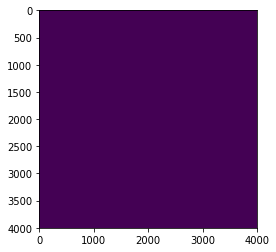

In [7]:
f, ax = plt.subplots()

with rasterio.open('/home/laurence/projects/raster-vision/data/rv/try1/predict/pv-detection-1/se3636_rgb_250_01.tif') as src:
    subset = src.read()
show(subset, ax=ax)
plt.show()

In [29]:
subset.shape

(1, 4000, 4000)

In [40]:
# Are they all class two (ie background)? Yes
set(subset[0].reshape(-1))

{2}

In [66]:
predictions = os.listdir('/home/laurence/projects/raster-vision/data/rv/test2/predict/pv-detection-1-test')

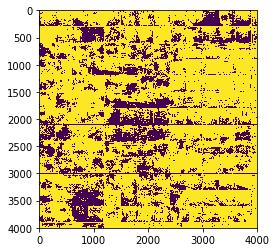

In [71]:
prediction = predictions[np.random.randint(0, len(predictions))]
with rasterio.open(f'/home/laurence/projects/raster-vision/data/rv/test2/predict/pv-detection-1-test/{prediction}') as src:
    subset = src.read()
show(subset)

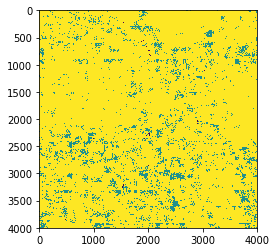

In [89]:
with rasterio.open(f'/home/laurence/projects/raster-vision/data/rv/test2/predict/pv-detection-1-test/so9051_rgb_250_04.tif') as src:
    subset = src.read()
show(subset)

In [86]:
subset.shape

(1, 4000, 4000)

## Problems
There are two principal errors right now.  
1. The solar PV is underrepresented in the training, and / or in validation so **predictions are all class 2** ie background.  
2. The evaluation seems to not be including the labels against the .tif images, I think because of the CRS issue. IE rasterio is defaulting to using WGS84 instead of BNG because this is not specified in the worldfile.  

For problem 2., I can reformat the worldfiles AND labels into WGS84, but this is pretty tedious. Or I can try and hardcode in that rasterio should use CRS BNG (epsg 27700) for all scenes even when CRS is not specified (preferred if I can work out how).  

Use a custom Evaluator in the experiment? 
From the docs:  
>For each task, there is an evaluator that computes metrics for a trained model. It does this by measuring the discrepancy between ground truth and predicted labels for a set of validation scenes.
>
>Normally you will not have to set any evaluators into the ExperimentConfig, as the default architecture will choose the evaluator that applies to the specific Task the experiment pertains to.  

https://docs.rastervision.io/en/0.9/api.html#evaluator-api-reference  

The Predict step is the problem step, as it turns pixel level predictions into 'map' level coordinate predictions. But how do I specify the CRS?  

And the Train and Eval step? I'm pretty sure TensorBoard isn't getting labels.

**Progress**
target_count_threshold: minimum number of pixels covering target_classes that a chip must have. Applies to the ‘random_sample’ window method.  

1000! 


## Images & Labels to WGS84

In [93]:
# geo = gpd.data/labels/nb1400_rgb_250_03.geojson
# data/labels/nb1400_rgb_250_03.jpg
# data/labels/nb1400_rgb_250_03.jgw

In [7]:
predictions = glob.glob('/home/laurence/projects/raster-vision/data/rv/try1/predict/pv-detection-1/*.tif')

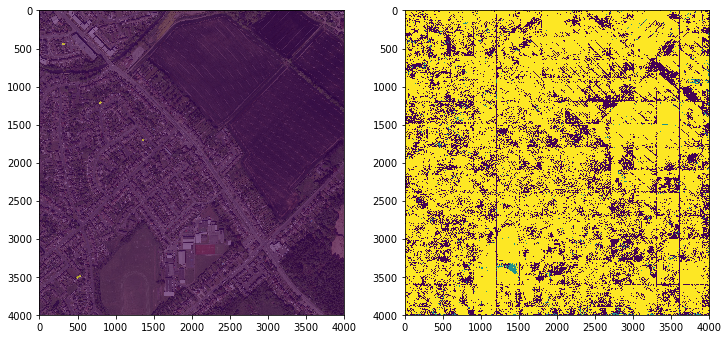

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

i = 5

orig = predictions[i].split('/')[-1].replace('tif', 'jpg')
lab = predictions[i].split('/')[-1].replace('tif', 'geojson')
label = bng(gpd.read_file(f'/home/laurence/projects/raster-vision/data/labels2/{lab}'))

with rasterio.open(f'/home/laurence/projects/raster-vision/data/labels2/{orig}') as src:
    show(src.read(), ax=ax1)

    transform = rasterio.transform.from_bounds(src.bounds[0], src.bounds[1], src.bounds[2], src.bounds[3], src.width, src.height)
    mask = geometry_mask(label.geometry, out_shape=(src.width,src.height), transform=transform, all_touched=False, invert=True)
    show(mask, ax=ax1, alpha=0.6, cmap='viridis')

with rasterio.open(predictions[i]) as pred:
    show(pred.read(), ax=ax2)

In [3]:
def show_img(name):
    ''' Takes image ID and returns original with image label mask
    '''
    # DESKTOP
#     root = '/home/laurence/projects/raster-vision/data/labels2/'
#     label = bng(gpd.read_file(f'{root}{name}.geojson'))

    # MACBOOK
    root = '/Users/laurence/Dropbox/ESDA/dissertation/data/labels/'
    label = gpd.read_file(f'{root}{name}.geojson')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    with rasterio.open(f'{root}{name}.jpg') as src:
        show(src.read(), ax=ax1)
        show(src.read(), ax=ax2)
        
        transform = rasterio.transform.from_bounds(src.bounds[0], src.bounds[1], src.bounds[2], src.bounds[3], src.width, src.height)
        mask = geometry_mask(label.geometry, out_shape=(src.width,src.height), transform=transform, all_touched=False, invert=True)
        show(mask, ax=ax1, alpha=0.6, cmap='viridis')


# Check Classification Data

In [3]:
# validation chips: 399 background and PV for so6462_rgb_250_04

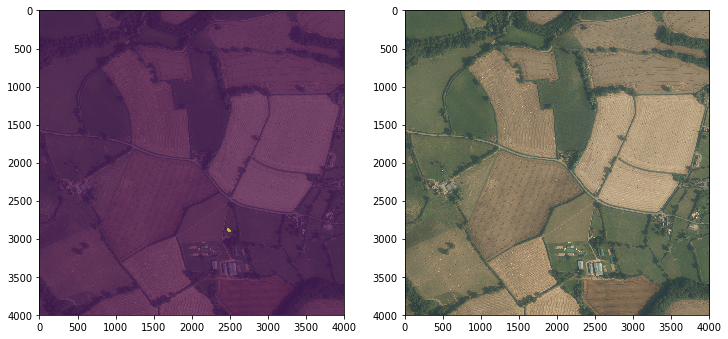

In [13]:
show_img('so6462_rgb_250_04')

No wonder there was only 1 chip out of 400 with PV... but how to adjust the weightings?!

# Duke Classification

In [4]:
duke = glob.glob('/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/duke-seg/*.tif')

In [242]:
len(duke)

93

## Get stats

In [5]:
root = '/home/laurence/projects/raster-vision-fastai-plugin/data/rv/'
eval_file = root + 'try2/eval/duke-seg/eval.json'
data = json.load(open(eval_file))

overall = pd.DataFrame(data["overall"])
scenes = pd.DataFrame(data["per_scene"])

In [199]:
overall

class_id  class_name                                           conf_mat  \
0       1.0          PV                          [0.0, 968414.0, 744108.0]   
1       2.0  Background                      [0.0, 280638.0, 2314006840.0]   
2       NaN     average  [[0.0, 0.0, 0.0], [0.0, 968414.0, 744108.0], [...   

    count_error        f1      gt_count  precision    recall  
0  30909.738223  0.649043  1.712522e+06   0.831908  0.565490  
1  11025.948434  0.999779  2.314287e+09   0.999679  0.999879  
2  11040.651123  0.999519  2.316000e+09   0.999555  0.999558

In [ ]:
# Get results from dataframe
results = pd.DataFrame(columns=['recall', 'f1','count_error','gt_count','class_id','class_name','id'])
for scene in scenes.columns.values:
    for i in range(3):
        row = pd.DataFrame(scenes.T.loc[scene][i]).drop('conf_mat', axis=1).drop_duplicates()
        row['id'] = scene
        results = pd.concat([results, row], sort=False)

In [200]:
results[results.class_name=='PV'].sort_values('f1', ascending=False).head(10)

recall        f1 count_error  gt_count class_id class_name           id  \
0   0.93371  0.943624        9334   83663.0        1         PV  10sfh480105   
0  0.883693  0.918164       21852  138719.0        1         PV  11ska565830   
0  0.929648   0.91333         316    1791.0        1         PV  11ska625680   
0  0.876413    0.8631        2902   10438.0        1         PV  11ska550740   
0  0.815313  0.850994       18120   63464.0        1         PV  10sfh480060   
0  0.796693  0.841724       13318   44450.0        1         PV  11ska520755   
0  0.763971  0.811402         483    1360.0        1         PV  11ska460680   
0    0.8943  0.805302       16115   37266.0        1         PV  10sfg540970   
0  0.889773  0.797657        1589    3520.0        1         PV  10sfh495000   
0  0.681148   0.78704       17793   48270.0        1         PV  10sfh450090   

  precision  
0  0.953751  
0  0.955434  
0  0.897574  
0  0.850186  
0  0.889942  
0   0.89215  
0  0.865112  
0  0.732413  
0  0.722825  
0  0.931918

### Second training (100 epochs)

In [301]:
root = '/home/laurence/projects/raster-vision-fastai-plugin/data/rv/'
eval_file = root + 'try2/eval/duke-seg2/eval.json'
data = json.load(open(eval_file))

overall = pd.DataFrame(data["overall"])
scenes = pd.DataFrame(data["per_scene"])

In [204]:
overall

class_id  class_name                                           conf_mat  \
0       1.0          PV                         [0.0, 1082916.0, 629606.0]   
1       2.0  Background                      [0.0, 448652.0, 2313838826.0]   
2       NaN     average  [[0.0, 0.0, 0.0], [0.0, 1082916.0, 629606.0], ...   

    count_error        f1      gt_count  precision    recall  
0  28050.100841  0.694823  1.712522e+06   0.827339  0.632352  
1  11601.015362  0.999767  2.314287e+09   0.999728  0.999806  
2  11613.178325  0.999542  2.316000e+09   0.999601  0.999534

In [202]:
# Get results from dataframe
results = pd.DataFrame(columns=['recall', 'f1','count_error','gt_count','class_id','class_name','id'])
for scene in scenes.columns.values:
    for i in range(3):
        row = pd.DataFrame(scenes.T.loc[scene][i]).drop('conf_mat', axis=1).drop_duplicates()
        row['id'] = scene
        results = pd.concat([results, row], sort=False)

In [291]:
results[results.class_name=='PV'].sort_values('f1', ascending=True).head(20)

recall          f1 count_error  gt_count class_id class_name  \
0  0.0993377  0.00586591       50843    1510.0        1         PV   
0   0.391481   0.0133278       28576     493.0        1         PV   
0  0.0493617    0.043203        2569    1175.0        1         PV   
0  0.0414781   0.0796524        2542    2652.0        1         PV   
0  0.0440252   0.0830671        2009    2067.0        1         PV   
0  0.0760042    0.126595       12115   11552.0        1         PV   
0  0.0868644    0.140893         500     472.0        1         PV   
0   0.221274    0.322797        1414    1523.0        1         PV   
0   0.214231    0.323139        1173    1307.0        1         PV   
0   0.537048    0.366667        3230    1741.0        1         PV   
0   0.297462    0.397468        2665    2955.0        1         PV   
0   0.654799    0.405492       54470   28369.0        1         PV   
0   0.278206    0.407388        1155    1427.0        1         PV   
0   0.633962    0.411324        3847    2120.0        1         PV   
0   0.320901    0.412152        3657    3995.0        1         PV   
0   0.315367     0.41643        9249   10464.0        1         PV   
0   0.294646    0.437917        2105    2783.0        1         PV   
0   0.308747    0.443285       12270   15822.0        1         PV   
0   0.341545    0.476179       26201   34868.0        1         PV   
0   0.332241     0.47748       35268   48501.0        1         PV   

            id   precision  
0  11ska640605  0.00302218  
0  11ska520665   0.0067793  
0  11ska490650   0.0384106  
0  11ska640725           1  
0  11ska580860    0.733871  
0  10sfh525090    0.378611  
0  11ska520710    0.372727  
0  10sfg465985     0.59646  
0  10sfh495105    0.657277  
0  11ska460725    0.278357  
0  11ska400725    0.598774  
0  11ska580830    0.293678  
0  10sfg495970    0.760536  
0  11ska445725    0.304417  
0  11ska550725    0.575921  
0  10sfg825685    0.612813  
0  11ska505845    0.852391  
0  11ska475755    0.785622  
0  11ska475770    0.786021  
0  11ska460800    0.848329

## See Predictions

In [6]:
def fix_crs(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in WGS84
    df = df.to_crs(crs={'init':'epsg:26911'})
    return df

/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/duke-seg/11ska565830.tif


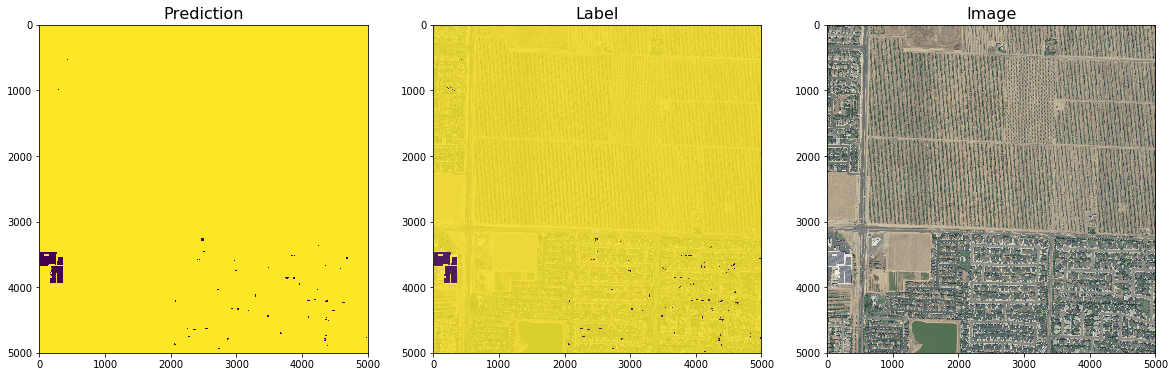

In [293]:
# Select prediction
# img = duke[8]
img = '/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/duke-seg/11ska565830.tif'

# startx, starty, lenx, leny
# win = [4000, 4000, 300, 300] # default
win = [0, 0, 5000, 5000] # default
window = rasterio.windows.Window(*win)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
print(img)
with rasterio.open(img) as src:
    show(src.read(window=window), ax=ax1)
    
    ax1.set_title('Prediction', fontsize=16)
    ax2.set_title('Label', fontsize=16)
    ax3.set_title('Image', fontsize=16)
    
    lab = '/home/laurence/projects/raster-vision-fastai-plugin/data/duke_labels/' + img.split('/')[-1].replace('tif', 'geojson')
    label = fix_crs(gpd.read_file(lab))
    
    with rasterio.open(img.replace('rv/try2/predict/duke-seg/', 'duke/')) as orig:
        transform = rasterio.transform.from_bounds(orig.bounds[0], orig.bounds[1], orig.bounds[2], orig.bounds[3], orig.width, orig.height)
        mask = geometry_mask(label.geometry, out_shape=(5000, 5000), transform=transform, all_touched=False, invert=False)
        
        show(orig.read(window=window), ax=ax2)
        show(orig.read(window=window), ax=ax3) 
        show(mask[win[1]:(win[1]+win[3]), win[0]:(win[0]+win[2])], ax=ax2, alpha=0.8, cmap='viridis')
# for ax in (ax1, ax2, ax3):
#     ax.axis('off')
plt.savefig('img/chart_duke_11ska565830_pred3.png', bbox_inches='tight', dpi=150)    

In [7]:
def plot_pred(image_id, exp_name='duke-seg', save=False, win=[0, 0, 5000, 5000], axes=False):
    """Image id eg 11ska565830
    Experiment name to choose correct folder
    Save - save an image or not with experiment id, image id and window dimensions
    Window to read in # startx, starty, lenx, leny
    # win = [4000, 4000, 300, 300] # default
    axes on or off
    """

    img = f'/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/{exp_name}/{image_id}.tif'
    window = rasterio.windows.Window(*win)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    ax1.set_title('Prediction', fontsize=16)
    ax2.set_title('Label', fontsize=16)
    ax3.set_title('Image', fontsize=16)
    print(img)
    
    lab = '/home/laurence/projects/raster-vision-fastai-plugin/data/duke_labels/' + img.split('/')[-1].replace('tif', 'geojson')
    label = fix_crs(gpd.read_file(lab))

    with rasterio.open(img) as src:
        with rasterio.open(img.replace(f'rv/try2/predict/{exp_name}/', 'duke/')) as orig:
            
            transform = rasterio.transform.from_bounds(orig.bounds[0], orig.bounds[1], orig.bounds[2], orig.bounds[3], orig.width, orig.height)
            mask = geometry_mask(label.geometry, out_shape=(5000, 5000), transform=transform, all_touched=False, invert=False)

            show(orig.read(window=window), ax=ax1)
            show(src.read(window=window), alpha=0.8, ax=ax1)
            
            show(orig.read(window=window), ax=ax2)
            show(orig.read(window=window), ax=ax3) 
            show(mask[win[1]:(win[1]+win[3]), win[0]:(win[0]+win[2])], ax=ax2, alpha=0.8, cmap='viridis')
    
    
#     ax1.set_yticks([0, 1000, 2000, 3000, 4000, 5000])
    
    if not axes:
        for ax in (ax2, ax3):
            ax.axis('off')
        # Flip y axis 
        for ax in (ax1, ax2, ax3):    
            ax.set_ylim(ax.get_ylim()[::-1])
            
    hide_splines(ax1)
    
    if save:
        plt.savefig(f'img/chart_{exp_name}_{image_id}_{"_".join([str(x) for x in win])}.png', bbox_inches='tight', dpi=150)    
    return

/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/duke-seg2/11ska565830.tif
/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/duke-seg2/11ska565830.tif
/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/predict/duke-seg2/11ska520665.tif


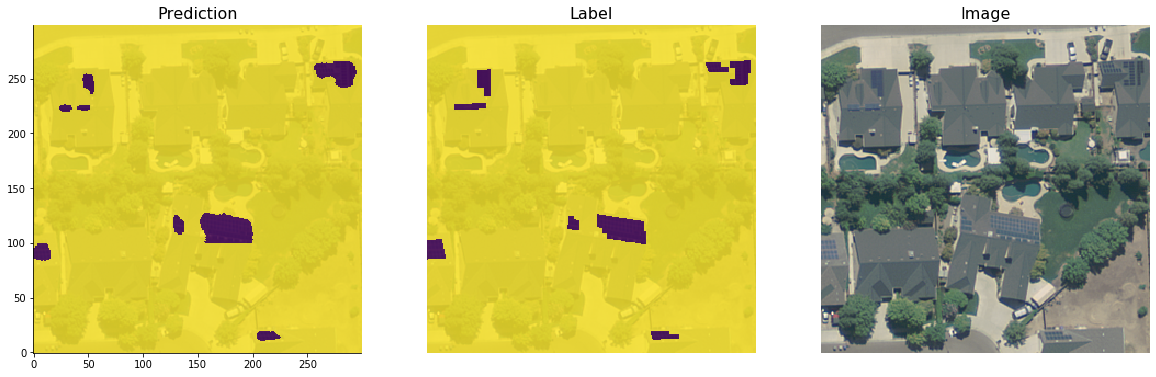

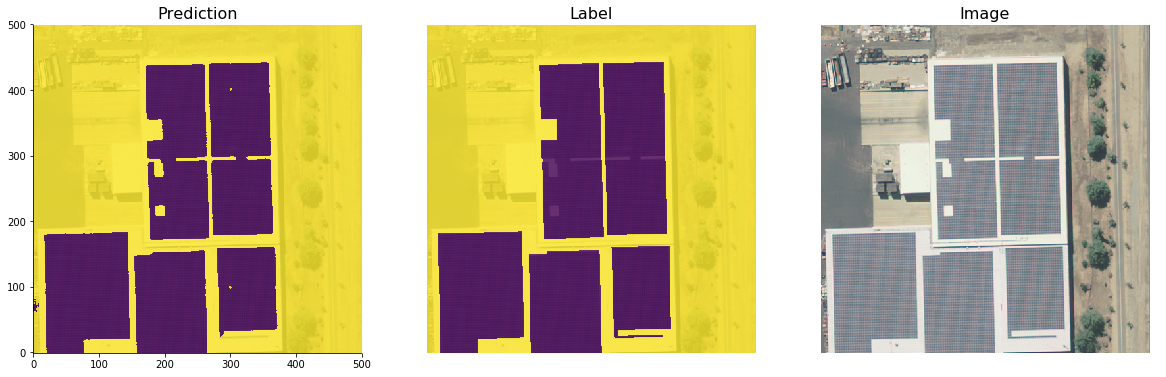

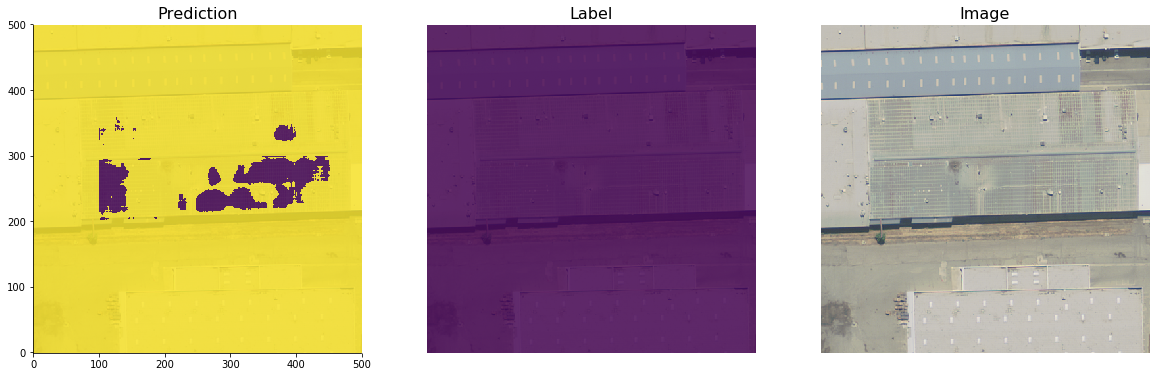

In [298]:
# Show successful predictions & label details
# plot_pred('11ska565830', 'duke-seg2', save=True)
# plot_pred('11ska565830', 'duke-seg2', save=True, win=[4200, 4100, 300, 300])
# plot_pred('11ska565830', 'duke-seg2', save=True, win=[0, 3500, 500, 500])

# Try find false positives
# plot_pred('11ska520665', 'duke-seg2', save=True, win=[2900, 3600, 500, 500])

# Graph the Training Log

In [302]:
log = root + 'try2/train/duke-seg2/log.csv'
log = pd.read_csv(log)

In [303]:
log.head(1)

epoch  train_loss  valid_loss  precision    recall    f_beta   time
0      0    2.859476    2.302773   0.994057  0.032008  0.058393  00:29

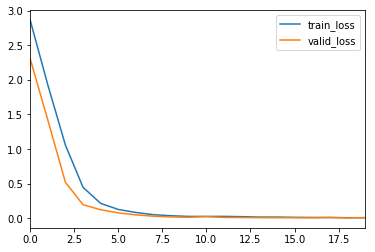

In [307]:
fig, ax = plt.subplots()
log[['train_loss', 'valid_loss']][:20].plot(ax=ax)

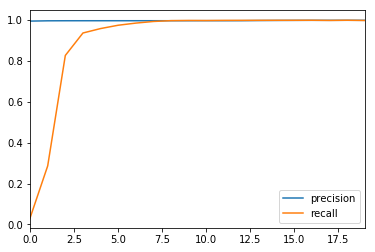

In [309]:
log[['precision', 'recall']][:20].plot()

# Set Up UK Predictions
Can be chip classification, then segmentation.

In [13]:
root = '/home/laurence/projects/raster-vision-fastai-plugin/data/true'

In [14]:
pv_true = [x.split('/')[-1].strip('.png') for x in glob.glob(root+'/pv_true/*.png')]
background_true = [x.split('/')[-1].strip('.png') for x in glob.glob(root+'/background_true/*.png')]

In [15]:
preds = [x.split('/')[-1].strip('.png') for x in glob.glob(root+'/data/*.png')]

In [16]:
def is_pv(x):
    if x in pv_true:
        return 1
    else:
        return 0

In [17]:
df = pd.DataFrame(columns=['name', 'pv'])

df['name'] = preds

df['pv'] = [is_pv(p) for  p in preds]

In [18]:
df.head(10)

name  pv
0    254   0
1   1423   0
2    320   0
3   1292   0
4  13199   1
5    202   0
6     27   0
7    477   0
8    113   0
9   1342   0

In [19]:
df.pv.value_counts()

0    272
1    123
Name: pv, dtype: int64

## Predict UK with RV

for predict command
'/home/laurence/projects/raster-vision-fastai-plugin/data/true/data'

> rastervision predict --help
Usage: python -m rastervision predict [OPTIONS] PREDICT_PACKAGE IMAGE_URI
                                      OUTPUT_URI

  Make predictions on the image at IMAGE_URI using PREDICT_PACKAGE and store
  the prediciton output at OUTPUT_URI.

Options:
  -a, --update-stats    Run an analysis on this individual image, as opposed
                        to using any analysis like statistics that exist in
                        the prediction package
  --channel-order TEXT  List of indices comprising channel_order. Example: 2 1
                        0
  --export-config PATH  Exports the configuration to the given output file.
  --help                Show this message and exit.
  
rastervision 


rastervision -p fastai predict /opt/data/rv/try2/bundle/duke-seg2/predict_package.zip /opt/data/true/data /opt/data/rv

In [20]:
def uk_seg(id, epoch=100):
    fig, ax = plt.subplots()
    with rasterio.open(f'/home/laurence/projects/raster-vision-fastai-plugin/data/true/data/{id}.png') as src:
        show(src.read(), ax=ax)
        with rasterio.open(f'/home/laurence/projects/raster-vision-fastai-plugin/data/true/output{epoch}/{id}.tif') as pred:
            show(pred.read(), ax=ax, alpha=0.6)
    return

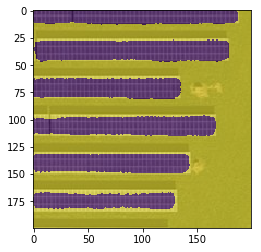

In [21]:
# 0, 1199, 3595, 10388
# id = 10388
uk_seg(11992)

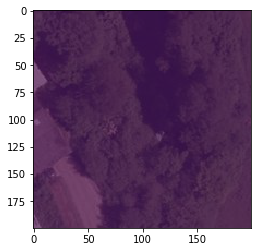

In [330]:
uk_seg(320)

In [22]:
pred_package = '/home/laurence/projects/raster-vision-fastai-plugin/data/rv/try2/bundle/duke-seg2/predict_package.zip'
root_dir = '/home/laurence/projects/raster-vision-fastai-plugin/data/true/data'
imgs = [x.split('/')[-1].strip('.png') for x in glob.glob(root_dir + '/*.png')]

In [23]:
ims = [int(x) for x in imgs]
chunk = sorted(ims, reverse=True)[:50]

In [24]:
def uk_seg_chunk(ids, epoch=100):
    fig, axes = plt.subplots(len(ids), 1, figsize=(20, 20))
    for i, id in enumerate(ids):
        with rasterio.open(f'/home/laurence/projects/raster-vision-fastai-plugin/data/true/data/{id}.png') as src:
            show(src.read(), ax=axes[i])
            with rasterio.open(f'/home/laurence/projects/raster-vision-fastai-plugin/data/true/output{epoch}/{id}.tif') as pred:
                show(pred.read(), ax=axes[i], alpha=0.6)
                if (df[df.name ==str(id)].pv.values[0]==1):
                    has_pv='Contains PV'
                else:
                    has_pv='No PV'
                axes[i].set_title(f'{id}, {has_pv}')
                axes[i].axis('off')
    return

In [25]:
# uk_seg_chunk(chunk)

In [26]:
# uk_seg_chunk(sorted(ims, reverse=True)[100:102])

In [27]:
test = rasterio.open(f'/home/laurence/projects/raster-vision-fastai-plugin/data/true/output/{ids[0]}.tif')
show(test.read())

NameError: name 'ids' is not defined

In [28]:
array = test.read(1)

pd.Series(array.reshape(-1)).value_counts()

NameError: name 'test' is not defined

## Check Epochs predictions: 20, 100, 500

In [29]:
imgs = [15196, 13596, 13598, 4796, 3199]

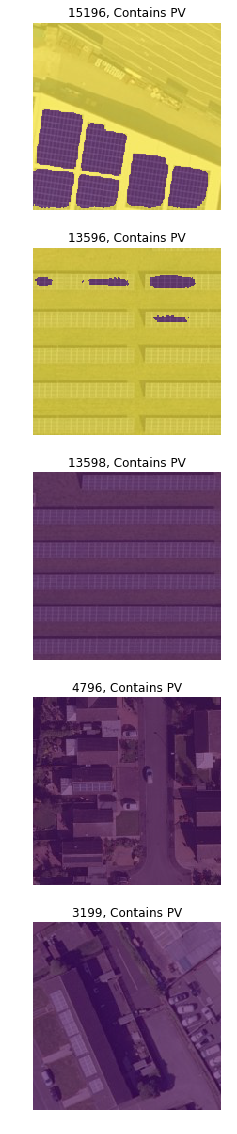

In [30]:
uk_seg_chunk(imgs, epoch=20)

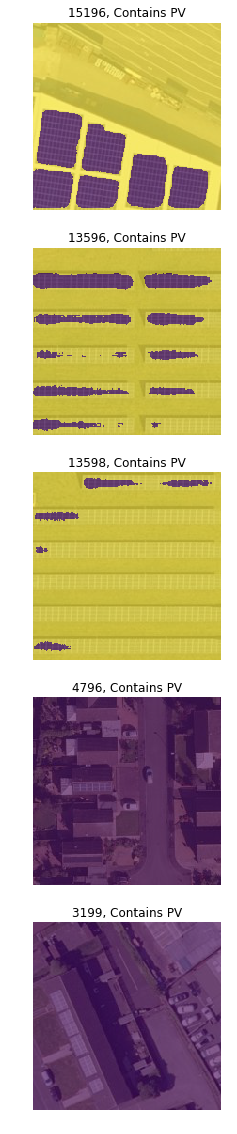

In [31]:
uk_seg_chunk(imgs, epoch=100)

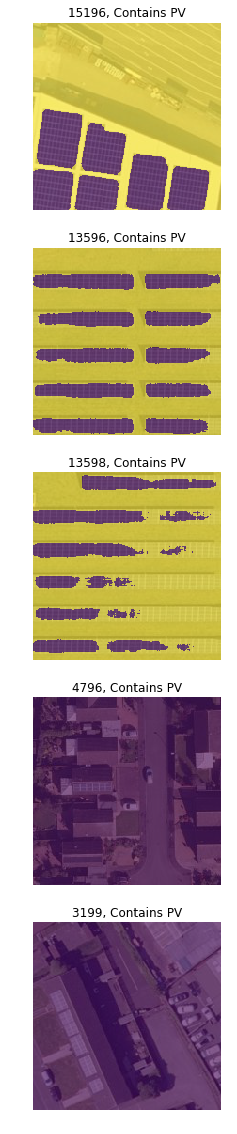

In [32]:
uk_seg_chunk(imgs, epoch=500)

### Get pixel counts per class per image

In [33]:
# result holder
px_counts = pd.DataFrame(columns=['name', 'pv_px', 'bg_px'])

In [35]:
imgs

[15196, 13596, 13598, 4796, 3199]

In [60]:
images = [x.split('/')[-1].strip('.tif') for x in glob.glob('/home/laurence/projects/raster-vision-fastai-plugin/data/true/data_preds' 
 + '/*.tif')]

In [61]:
images[:5]

['485', '1515', '15193', '360', '391']

In [62]:
for id in images:
    with rasterio.open(f'/home/laurence/projects/raster-vision-fastai-plugin/data/true/data_preds/{id}.tif') as img:
        array = img.read(1)
        counts = pd.Series(array.reshape(-1)).value_counts()
        try:
            data = [id, counts[1], counts[2]]
        except:
            data = [id, 0, counts[2]]
        px_counts = px_counts.append(pd.DataFrame(data=[data], columns=['name', 'pv_px', 'bg_px']))

### Combine with PV yes/no

In [87]:
df['name'] = pd.to_numeric(df['name'])

In [88]:
px_counts['name'] = pd.to_numeric(px_counts['name'])

In [89]:
stats = pd.merge(px_counts, df, left_on='name', right_on='name')

Precision = number of true positives out of all positives  
Recall = number of true positives out of all true  
F1 score = 2 * (precision*recall)/(precision+recall)

In [90]:
stats['pv_pred'] = stats['pv_px'].apply(lambda x: int(x>0))

In [91]:
true_positives = stats[(stats.pv==1) & (stats.pv_pred==1)].count()['name']
all_positives = stats['pv_pred'].sum()
all_true = stats['pv'].sum()

precision = round(true_positives/all_positives, 3)
recall = round(true_positives/all_true, 3)
f = round(2*(precision*recall)/(precision+recall), 3)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f}')

Precision: 1.0
Recall: 0.589
F1 score: 0.741
